# FAKE NEWS DETECTION

### AIM : The dataset consists of about 40000 articles consisting of fake as well as real news. Train a model to correctly predict whether a given piece of news is real or fake.

### LOADING THE NECESSARY LIBRARIES

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

### IMPORTING THE DATASET

In [20]:
true = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
false = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")

In [21]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [22]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [23]:
true['category'] = 1
false['category'] = 0

In [24]:
df = pd.concat([true,false]) #concating the datasets

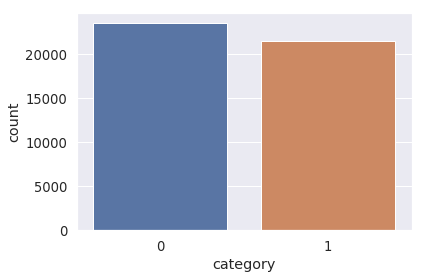

In [25]:
sns.set_style("darkgrid")
sns.countplot(df.category) # Count plot for true and false

##### It can be observed that data is balanced

In [26]:
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

##### no null values are present

In [28]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

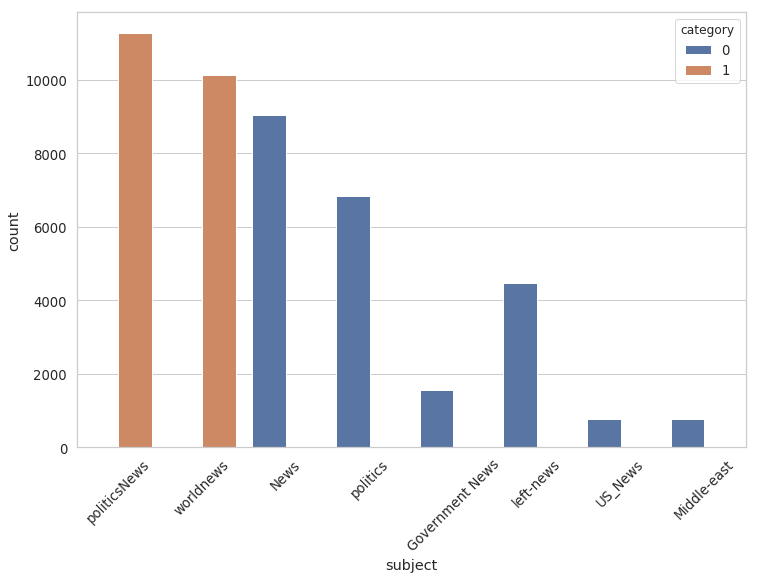

In [29]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)

##### Topics in subject columns in both categories are different, hence it should be excluded from the text

In [31]:
df['text'] = df['text'] + " " + df['title'] # merging text in "text" and "title" columns

In [32]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [35]:
df.drop(['title', 'subject', 'date'], axis = 1, inplace = True) #dropping unnecessary columns

In [66]:
df.reset_index(inplace = True) # reseting the index

#### Stopwords are the English words which does not add much meaning to a sentence and can be removed safely

In [40]:
stop = set(stopwords.words('english')) # set of stop words
punctuation = list(punctuation) # list of punctuations
stop.update(punctuation) # set of stop word and punctuations

### DATA CLEANING

In [65]:
import re,string

In [67]:
# Removing stopwords 
def remove_stopwords(text):
    fintext = []
    for i in text.split():
        if i.strip().lower() not in stop:
            fintext.append(i.strip())
    return " ".join(fintext)

#Removing square brackets
def remove_sq_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# removing URLs
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)



#Removing the noisy text
def text_cleaning(text):
#     text = strip_html(text)
    text = remove_sq_brackets(text)
    text = remove_stopwords(text)
    return text


#Apply function on review column
df['text']=df['text'].apply(text_cleaning)

### WORDCLOUD: REAL TEXT

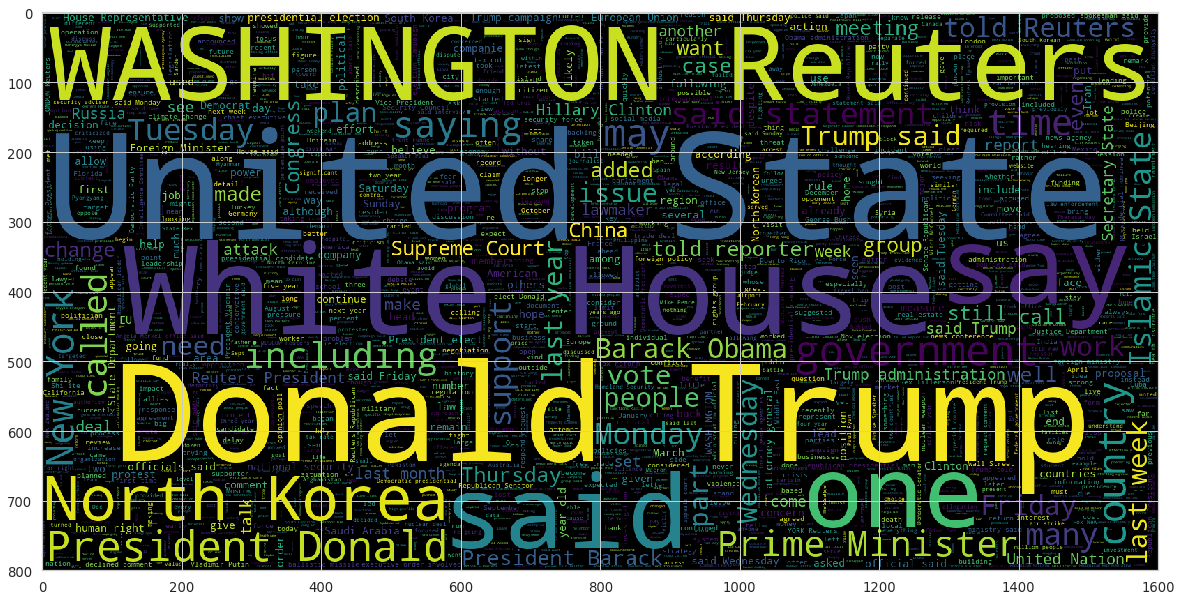

In [69]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc)

### WORDCLOUD: FAKE TEXT 

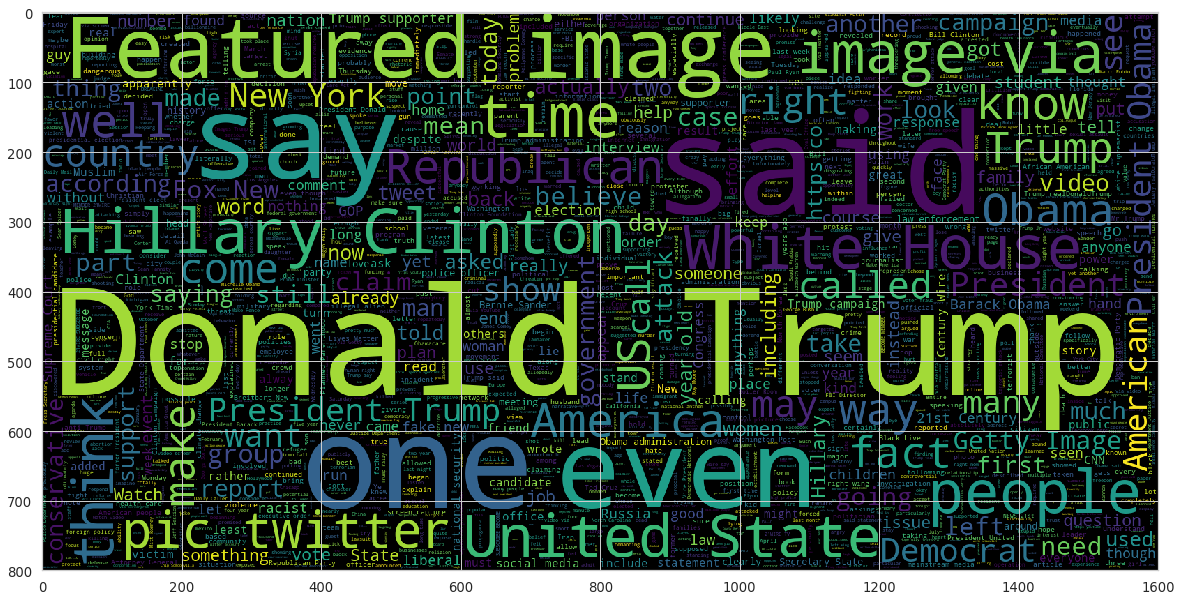

In [70]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc)

#### Number of characters in texts

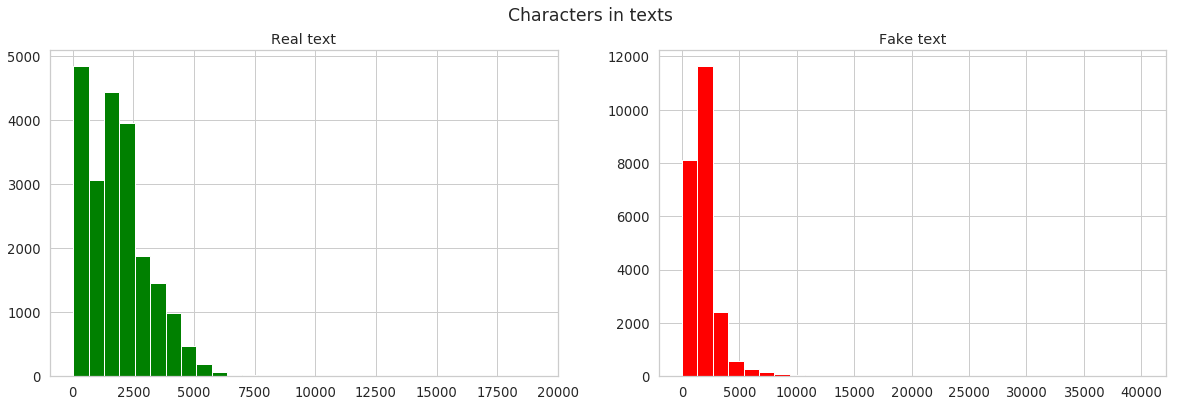

In [91]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,6))
fig.suptitle('Characters in texts')

real_=df[df['category']==1]['text'].str.len() # for real text
ax1.hist(real_,color='green', bins = 30)
ax1.set_title('Real text')

fake_=df[df['category']==0]['text'].str.len() # for fake text
ax2.hist(fake_,color='red', bins = 30)
ax2.set_title('Fake text')

plt.show()

#### Number of words in each text

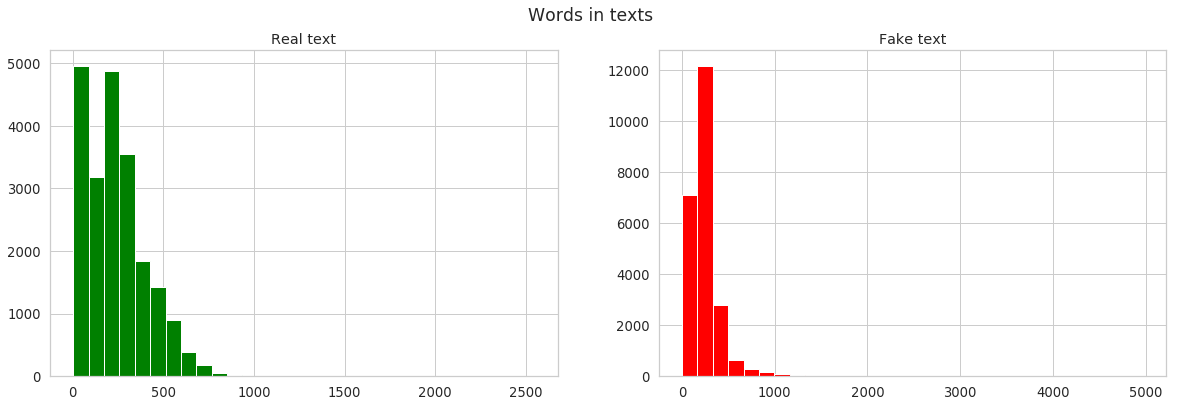

In [90]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,6))
fig.suptitle('Words in texts')

real_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x)) # for real
ax1.hist(real_len,color='green', bins = 30)
ax1.set_title('Real text')

fake_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x)) # for fake
ax2.hist(fake_len,color='red', bins = 30)
ax2.set_title('Fake text')

plt.show()

In [92]:
def getCorpus(text): # getting corpus
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words

corpus = getCorpus(df["text"])

In [94]:
len(corpus)

11055479

In [101]:
from collections import Counter
counter = Counter(corpus) # count the frequency of each word in corpus
mostCommon = counter.most_common(10) # top 10 most common words
mostCommon = dict(mostCommon)
mostCommon

{'Trump': 111486,
 'said': 93144,
 'would': 54601,
 'U.S.': 50430,
 'President': 33171,
 'people': 33107,
 'also': 30316,
 'one': 29363,
 'Donald': 27796,
 'said.': 26189}

In [102]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g): # funtion to get top ngrams 
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Unigrams

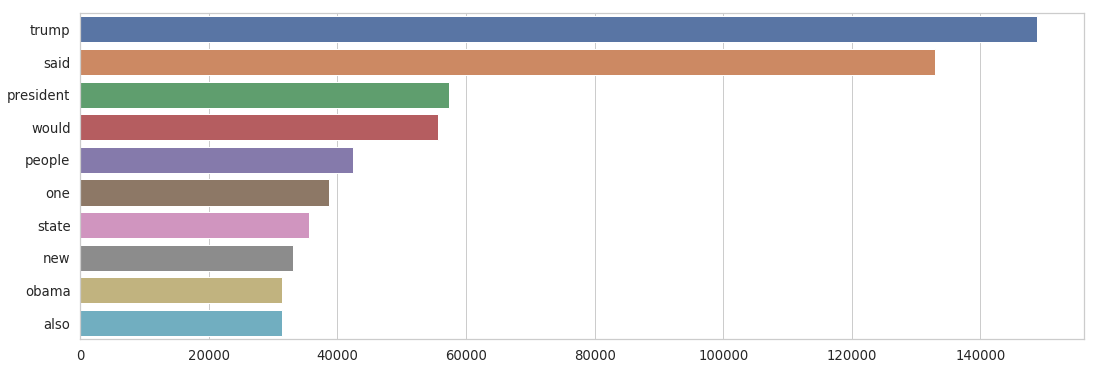

In [106]:
plt.figure(figsize = (18,6))
uni = get_top_text_ngrams(df.text,10,1) # top 10 1 grams
uni = dict(uni)
sns.barplot(x=list(uni.values()),y=list(uni.keys()))

### Bigrams

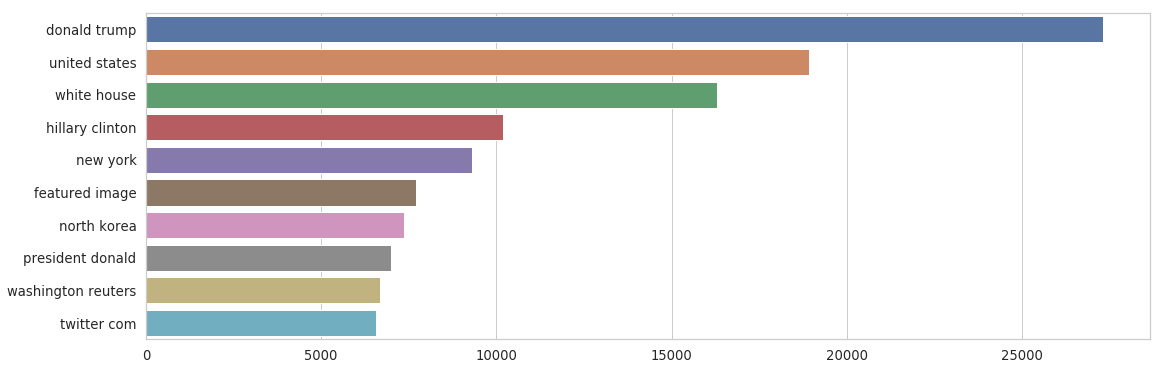

In [108]:
plt.figure(figsize = (18,6))
bi = get_top_text_ngrams(df.text,10,2) # top 10 2 grams
bi = dict(bi)
sns.barplot(x=list(bi.values()),y=list(bi.keys()))

### Trigrams

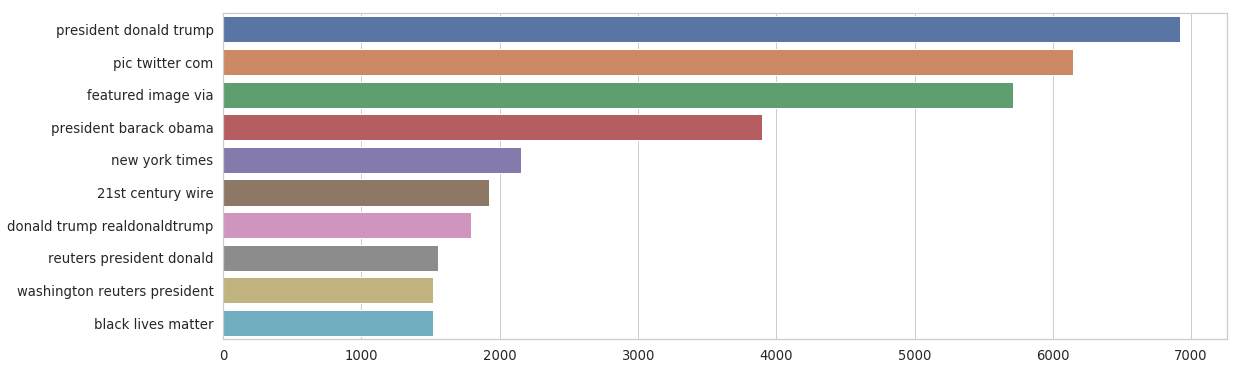

In [109]:
plt.figure(figsize = (18,6))
tri = get_top_text_ngrams(df.text,10,3) # top 10 3 grams
tri = dict(tri)
sns.barplot(x=list(tri.values()),y=list(tri.keys()))

### Splitting the dataset into train and test set

In [117]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0, shuffle = True)

In [118]:
max_features = 10000 # max length of each word vector
maxlen = 300 # max words in a text

##### Tokenizing Text : Repsesenting each word by a number
##### Tokenized applies basic processing like changing it to lower case
##### Here we are keeping all text to 300 words, padding the short text and truncating long text.

In [119]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenizedTrain = tokenizer.texts_to_sequences(x_train)
X_train = sequence.pad_sequences(tokenizedTrain, maxlen=maxlen)

In [120]:
tokenizedTest = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenizedTest, maxlen=maxlen)

### Applying GloVe Embeddings

In [130]:
EMBEDDING_FILE = '../input/glove-twitter/glove.twitter.27B.100d.txt' # importing embedding file

In [131]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [132]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [171]:
X_train.shape

(33673, 300)

In [133]:
# setting model parameters
batch_size = 256
epochs = 10
embed_size = 100
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2,factor=0.5, min_lr=0.00001)

### TRAINING THE LSTM MODEL

##### Long Short Term Memory is a kind of recurrent neural network. In RNN output from the last step is fed as input in the current step. LSTM was designed by Hochreiter & Schmidhuber. It tackled the problem of long-term dependencies of RNN in which the RNN cannot predict the word stored in the long-term memory but can give more accurate predictions from the recent information. As the gap length increases RNN does not give an efficient performance. LSTM can by default retain the information for a long period of time. It is used for processing, predicting, and classifying on the basis of time-series data.  

In [134]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))

model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [135]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [137]:
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [lr_reduction])

Train on 33673 samples, validate on 11225 samples
Epoch 1/10
33673/33673 [==============================] - 75s 2ms/step - loss: 0.1641 - accuracy: 0.9318 - val_loss: 0.0313 - val_accuracy: 0.9899
Epoch 2/10
33673/33673 [==============================] - 73s 2ms/step - loss: 0.0500 - accuracy: 0.9842 - val_loss: 0.0202 - val_accuracy: 0.9932
Epoch 3/10
33673/33673 [==============================] - 73s 2ms/step - loss: 0.0294 - accuracy: 0.9894 - val_loss: 0.0157 - val_accuracy: 0.9948
Epoch 4/10
33673/33673 [==============================] - 72s 2ms/step - loss: 0.0280 - accuracy: 0.9917 - val_loss: 0.0099 - val_accuracy: 0.9971
Epoch 5/10
33673/33673 [==============================] - 73s 2ms/step - loss: 0.0161 - accuracy: 0.9947 - val_loss: 0.0128 - val_accuracy: 0.9966
Epoch 6/10
33673/33673 [==============================] - 73s 2ms/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.0086 - val_accuracy: 0.9968
Epoch 7/10
33673/33673 [==============================] - 72s 2ms/st

In [138]:
print("Accuracy on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

33673/33673 [==============================] - 89s 3ms/step
Accuracy on Training Data is -  99.97624158859253 %
11225/11225 [==============================] - 29s 3ms/step
Accuracy on Testing Data is -  99.89309310913086 %


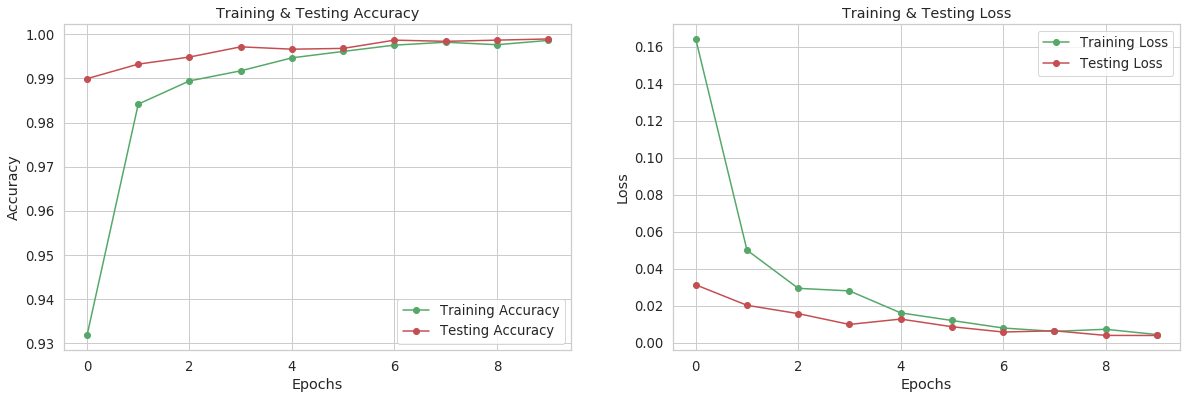

In [170]:
epochs = range(10)
# fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
# fig.set_size_inches(20,10)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,6))
ax1.plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax1.plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax1.set_title('Training & Testing Accuracy')
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")

ax2.plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax2.plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax2.set_title('Training & Testing Loss')
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
plt.show()

#### From the above plots it is clear that LSTM netowk perform really well on text data.

In [143]:
pred = model.predict_classes(X_test)

In [145]:
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
        Real       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



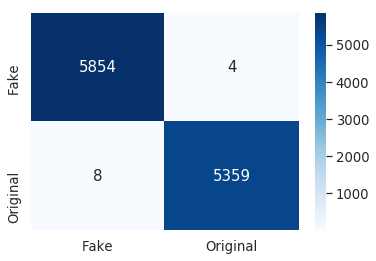

In [151]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm,annot = True, annot_kws = {'fontsize':15}, fmt = 'g',cmap = 'Blues', xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])

### Applying SVM Classifier

In [152]:
from sklearn.svm import SVC

In [154]:
model_svc = SVC(C = 0.25, kernel = "rbf")
model_svc.fit(X_train, y_train)
svm_preds = model_svc.predict(X_test)

In [157]:
print(classification_report(y_test, svm_preds, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.63      0.80      0.71      5858
        Real       0.69      0.49      0.57      5367

    accuracy                           0.65     11225
   macro avg       0.66      0.64      0.64     11225
weighted avg       0.66      0.65      0.64     11225



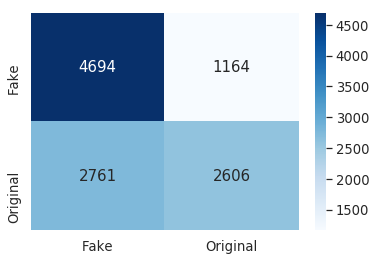

In [156]:
cm = confusion_matrix(y_test,svm_preds)
sns.heatmap(cm,annot = True, annot_kws = {'fontsize':15}, fmt = 'g',cmap = 'Blues', xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])

#### SVM Classifier does not perform well in comparison to LSTMs because the size of the data is high and SVM classifier does not consider the contextual information of the text while making decision. 